In [ ]:
# ─── Célula 1 ▸ Instalação de dependências ───────────────────────────
# (roda uma única vez por ambiente)

# Core
!pip install opendatasets pandas imagehash --upgrade pillow

# Modelagem e validação
!pip install scikit-learn tqdm

# Deep Learning  (troque por tensorflow‑cpu se não tiver GPU Nvidia/CUDA)
!pip install tensorflow

In [ ]:
# ─── Célula 2 ▸ Imports principais ───────────────────────────────────

# Utilidades gerais
import os, glob, hashlib, random, shutil
from shutil import copyfile
import pandas as pd
import numpy as np

# Deep Learning
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Visualização
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import matplotlib.patches as mpatches

# Validação e split sem vazamento
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, StratifiedKFold

# Barra de progresso
from tqdm import tqdm

# Download dataset do Kaggle
import opendatasets as od

import cv2

from pathlib import Path
from PIL import Image, UnidentifiedImageError, ImageFile
import imagehash            # calcula o p‑hash

In [ ]:
od.download("https://www.kaggle.com/datasets/mdwaquarazam/agricultural-crops-image-classification/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Denise Soares
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mdwaquarazam/agricultural-crops-image-classification


In [ ]:
#só rodar se houver problema e tiver que excluir a pasta do dataset
!rm -rf agricultural-crops-image-classification

In [ ]:
!ls

agricultural-crops-image-classification  sample_data


In [ ]:
!ls agricultural-crops-image-classification

Agricultural-crops


## 🧠 O que essa célula faz, afinal?

Varredura inicial de reconhecimento do território: ela percorre todo o dataset de imagens de culturas agrícolas e extrai metadados importantes sobre cada imagem (como tamanho, formato, classe, integridade e um tipo especial de “impressão digital visual” chamado perceptual hash). Tudo isso vai parar num DataFrame, que servirá de base pra futuras análises ou tratamentos — como detecção de duplicatas, imagens corrompidas ou inconsistências.

## 🎯 Resumo dos conceitos principais usados no código

| Conceito             | Explicação                                                    |
|----------------------|----------------------------------------------------------------|
| `pathlib` + `rglob`  | Caminhamento recursivo por arquivos e subpastas               |
| `PIL.Image`          | Abre e lê metadados de imagens                                |
| `imagehash.phash`    | Cria hash visual para comparar imagens                        |
| `try/except`         | Captura e trata imagens corrompidas                           |
| `DataFrame`          | Organiza os dados coletados em tabela para análise            |


In [ ]:
# ─── Celula 3 Config ──────────────────────────────────────────────────────────
root_dir = "agricultural-crops-image-classification"
ImageFile.LOAD_TRUNCATED_IMAGES = False        # muda pra True se quiser tentar abrir mesmo quebrada

rows = []

# ─── Varredura ───────────────────────────────────────────────────────
for path in tqdm(Path(root_dir).rglob("*.*"), desc="Scanning images"):
    if not path.is_file():
        continue
    label = path.parent.name                     # nome da pasta = classe
    try:
        with Image.open(path) as im:
            w, h           = im.size
            img_format     = im.format.lower()
            img_hash       = imagehash.phash(im)  # perceptual hash 64‑bit
            corrupted      = False
    except (UnidentifiedImageError, OSError):     # não conseguiu abrir = corrompida/inválida
        w = h = img_format = img_hash = None
        corrupted = True

    rows.append({
        "filepath" : str(path),
        "label"    : label,
        "width"    : w,
        "height"   : h,
        "format"   : img_format,
        "phash"    : str(img_hash),
        "corrupted": corrupted
    })

# ─── DataFrame ───────────────────────────────────────────────────────
df = pd.DataFrame(rows)
print(f"Total de imagens: {len(df)}")
print(f"Corrompidas: {df['corrupted'].sum()}")

df.head()


Scanning images: 829it [00:07, 103.67it/s]

Total de imagens: 829
Corrompidas: 0


,filepath,label,width,height,format,phash,corrupted
0,agricultural-crops-image-classification/Agricu...,wheat,1200,800,jpeg,80bf50da07073daf,False
1,agricultural-crops-image-classification/Agricu...,wheat,1200,675,webp,d1034e1c39f706bd,False
2,agricultural-crops-image-classification/Agricu...,wheat,534,400,jpeg,fe091443e87a2f96,False
3,agricultural-crops-image-classification/Agricu...,wheat,300,168,jpeg,8c9c470393d67eb4,False
4,agricultural-crops-image-classification/Agricu...,wheat,275,183,jpeg,8a8e155d7a67a45a,False


In [ ]:
#Informações estatísticas dos valores de altura, largura e canais das imagens

df.describe().loc[['mean', 'std', 'min', 'max']]

,width,height
mean,564.150784,419.332931
std,481.731456,359.262379
min,100.000000,100.000000
max,4875.000000,3251.000000


Text(0.5, 1.0, 'Distribuição das larguras')

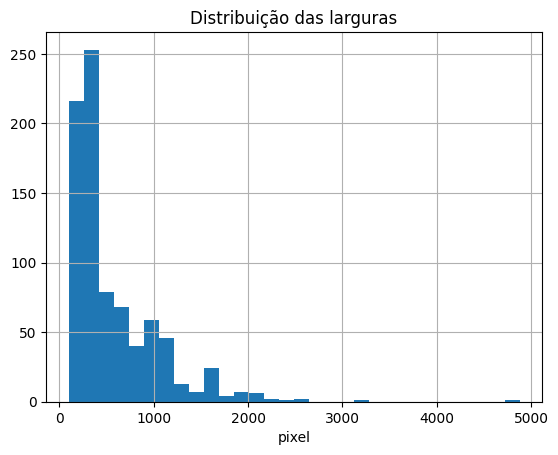

In [ ]:
#Histograma de larguras
df['width'].hist(bins=30)
plt.xlabel('pixel'); plt.title('Distribuição das larguras')


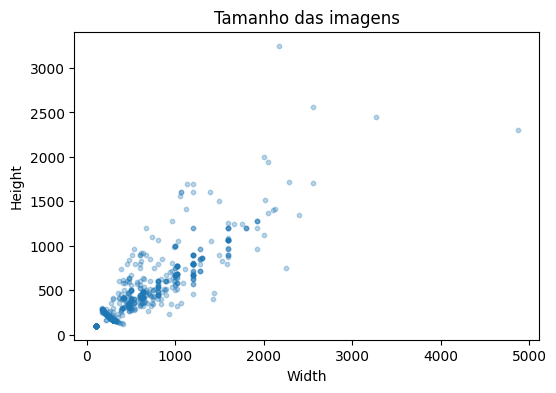

(array([0, 1, 2, 3]),
 [Text(0, 0, 'jpeg'),
  Text(1, 0, 'png'),
  Text(2, 0, 'webp'),
  Text(3, 0, 'mpo')])

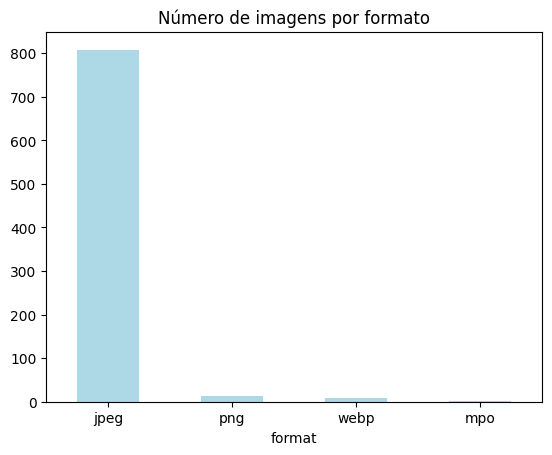

In [ ]:
#Distribuição altura × largura num scatter
plt.figure(figsize=(6,4))
plt.scatter(df['width'], df['height'], alpha=0.3, s=10)
plt.xlabel('Width'); plt.ylabel('Height'); plt.title('Tamanho das imagens')
plt.show()

# Contagem por formato
df['format'].value_counts().plot.bar(color='lightblue')
plt.title('Número de imagens por formato'); plt.xticks(rotation=0)


## 🧠 O que essa célula faz, afinal?

Essa célula serve para **Visualizar os grupos de imagens duplicadas** com base no _perceptual hash_ (phash). Após identificar quais imagens possuem o mesmo phash (ou seja, são visualmente muito parecidas ou idênticas), ela organiza os maiores grupos e exibe as imagens lado a lado para inspeção visual.

É uma ferramenta essencial na etapa de análise exploratória, especialmente para validar se duplicatas devem ser removidas ou redistribuídas corretamente no treino/validação/teste.

---

## 🎯 Resumo dos conceitos principais usados no código

| Conceito                 | Explicação                                                                 |
|--------------------------|----------------------------------------------------------------------------|
| `groupby` + `filter`     | Agrupa imagens por phash e filtra grupos com mais de uma ocorrência        |
| `matplotlib.pyplot`      | Usado para criar as visualizações das imagens duplicadas                   |
| `mpimg.imread`           | Lê os arquivos de imagem para exibição                                     |
| `subplots`               | Cria uma grade de gráficos (linhas e colunas) para exibir imagens lado a lado |
| `phash`                  | Representa a assinatura visual da imagem, usada para identificar duplicatas |
| `plt.tight_layout()`     | Ajusta automaticamente os espaçamentos entre gráficos para melhor legibilidade |

---

## 💡 Observação

- A célula exibe até **3 dos maiores grupos** de duplicatas, mas esse número pode ser alterado no código (`[:3]`).
- O código também trata o caso em que só há um grupo, garantindo que `axes` seja sempre iterável.
- Se não houver duplicatas, um `ValueError` é lançado com uma mensagem amigável.



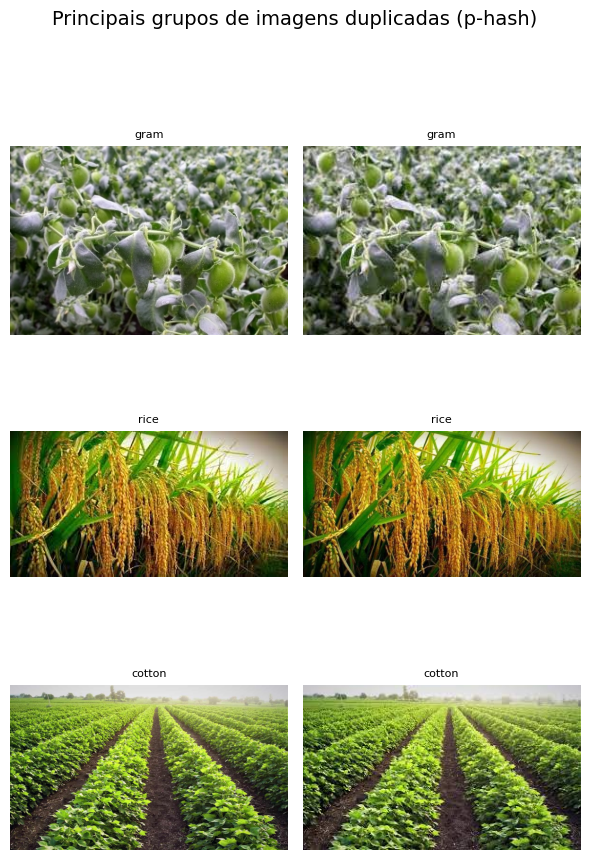

In [ ]:
# Visualizar grupos de imagens duplicadas ─────────────────────────
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

# Seleciona hashes com mais de 1 ocorrência
dup_groups = (df.groupby('phash')
                .filter(lambda g: len(g) > 1)
                .groupby('phash'))

if len(dup_groups) == 0:
    raise ValueError("Não há duplicatas para exibir 🚀")

# Pega os 3 maiores grupos (ajuste como quiser)
top_hashes = sorted(dup_groups.groups,
                    key=lambda h: len(dup_groups.get_group(h)),
                    reverse=True)[:3]

rows = len(top_hashes)
cols = max(len(dup_groups.get_group(h)) for h in top_hashes)

fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
if rows == 1:                # caso só 1 grupo
    axes = [axes]            # garante iterável

for r, phash in enumerate(top_hashes):
    gdf = dup_groups.get_group(phash).reset_index(drop=True)
    for c in range(cols):
        ax = axes[r][c] if rows > 1 else axes[c]
        if c < len(gdf):
            fp    = gdf.loc[c, 'filepath']
            label = gdf.loc[c, 'label']
            img   = mpimg.imread(fp)
            ax.imshow(img)
            ax.set_title(label, fontsize=8)
        ax.axis('off')

plt.suptitle("Principais grupos de imagens duplicadas (p‑hash)",
             fontsize=14, y=1.03)
plt.tight_layout()
plt.show()


In [ ]:
# Agrupando todas as imagens com phash repetido
df_duplicated = df[df.duplicated(subset='phash', keep=False)]

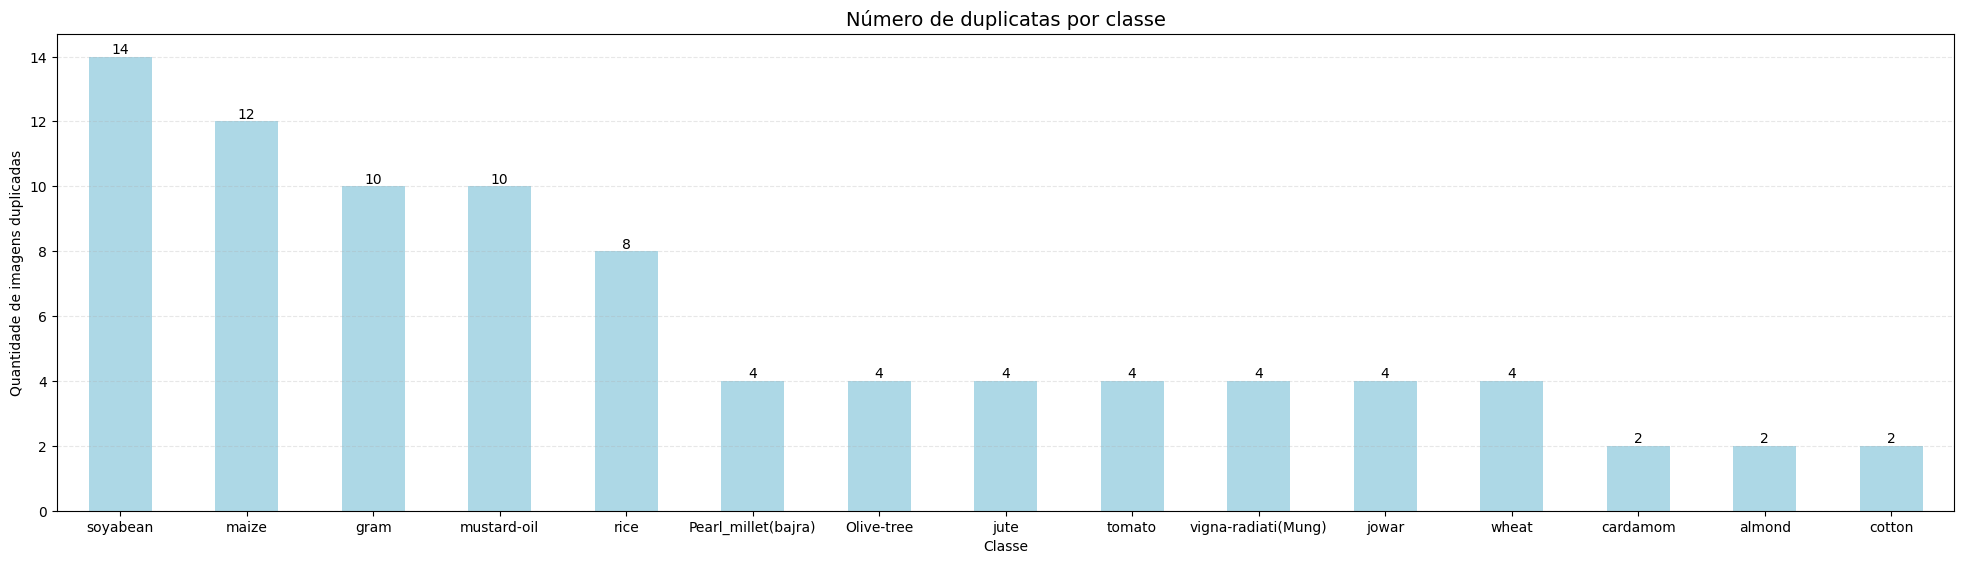

In [ ]:
# Número de duplicatas por classe
duplicates_by_class = df_duplicated.groupby('label').size().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(20, 6))  # container maior, boa prática!

# Barras
bars = duplicates_by_class.plot(kind='bar',
                                ax=ax,
                                title='Número de duplicatas por classe',
                                color='lightblue')

# Anotação dos valores
for bar in ax.patches:
    h = bar.get_height()
    ax.annotate(f'{int(h)}',
                (bar.get_x() + bar.get_width() / 2, h),
                ha='center', va='bottom', fontsize=10)

# Estética
ax.set_xlabel("Classe")
ax.set_ylabel("Quantidade de imagens duplicadas")
ax.set_title("Número de duplicatas por classe", fontsize=14)
plt.xticks(rotation=0, ha='center')     # ← horizontal, centralizado
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout(pad=2.0)
plt.show()


In [ ]:
# Conta quantas imagens há por hash
phash_counts = df.groupby('phash').size()

# Filtra apenas os hashes duplicados
duplicated_hashes = phash_counts[phash_counts > 1]

# Volta para o dataframe principal e soma quantas duplicadas existem por classe
df_duplicated = df[df['phash'].isin(duplicated_hashes.index)]

# Para saber quantas CÓPIAS são redundantes (exceto 1 por grupo)
redundant_counts = df_duplicated.groupby('phash').size() - 1

# Junta com os labels
phash_to_label = df_duplicated.drop_duplicates(subset='phash')[['phash', 'label']].set_index('phash')
redundant_by_class = (redundant_counts.to_frame('redundant')
                      .join(phash_to_label)
                      .groupby('label')['redundant']
                      .sum()
                      .sort_values(ascending=False))


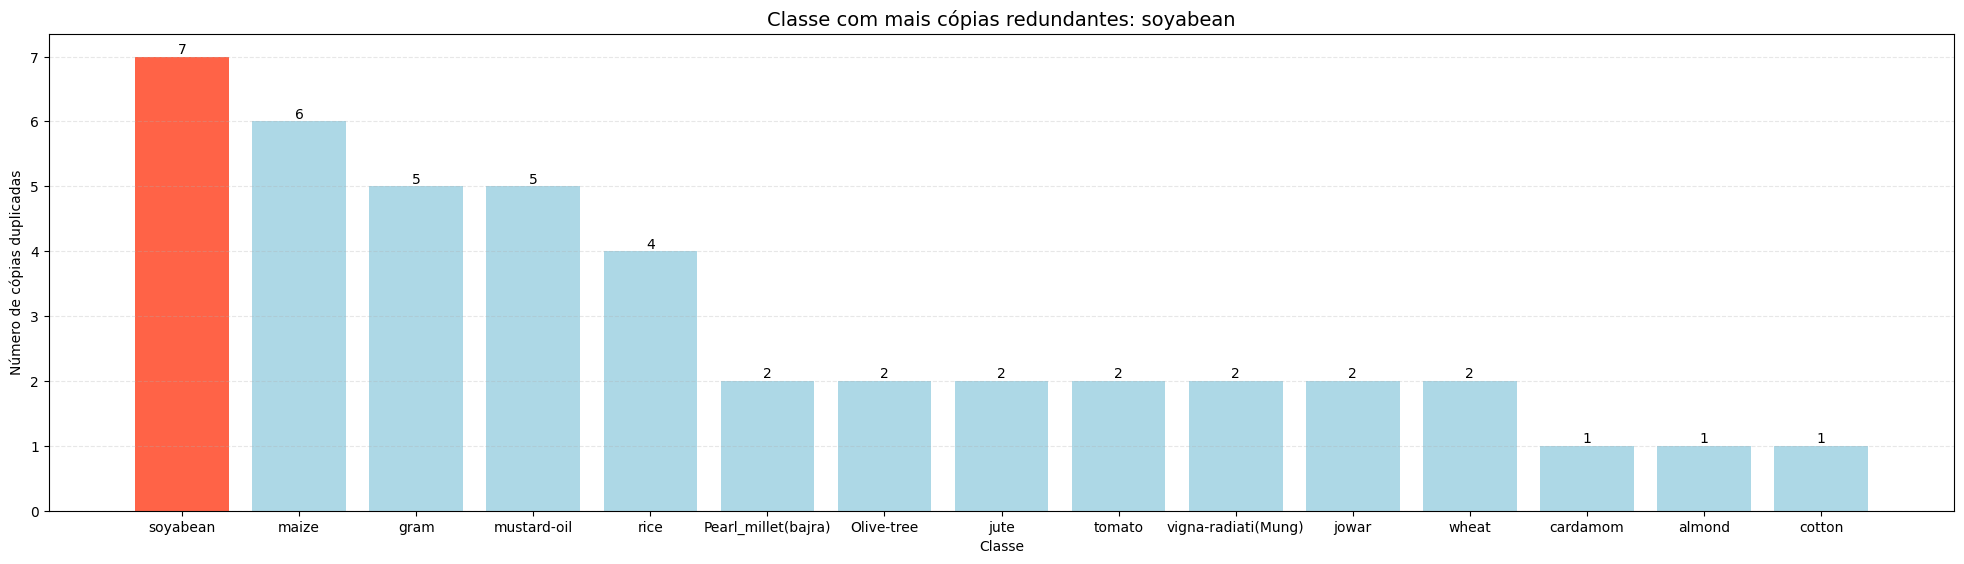

In [ ]:
# Gráfico: Número de duplicatas por classe (cópias extras agrupadas por classe)
top_class = redundant_by_class.idxmax()
top_count = redundant_by_class.max()

fig, ax = plt.subplots(figsize=(20, 6))

bars = ax.bar(redundant_by_class.index, redundant_by_class.values,
              color=['tomato' if cls == top_class else 'lightblue' for cls in redundant_by_class.index])

# Adiciona os valores numéricos acima de cada barra
for bar in bars:
    h = bar.get_height()
    ax.annotate(f'{int(h)}',
                (bar.get_x() + bar.get_width() / 2, h),
                ha='center', va='bottom', fontsize=10,
                fontweight='bold' if bar.get_facecolor() == (1.0, 0.3882, 0.2784, 1.0) else 'normal')

# Estilo do gráfico
plt.title(f"Classe com mais cópias redundantes: {top_class}", fontsize=14)
plt.xlabel("Classe")
plt.ylabel("Número de cópias duplicadas")
plt.xticks(rotation=0, ha='center')  # <-- rótulos na horizontal
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout(pad=2.0)
plt.show()

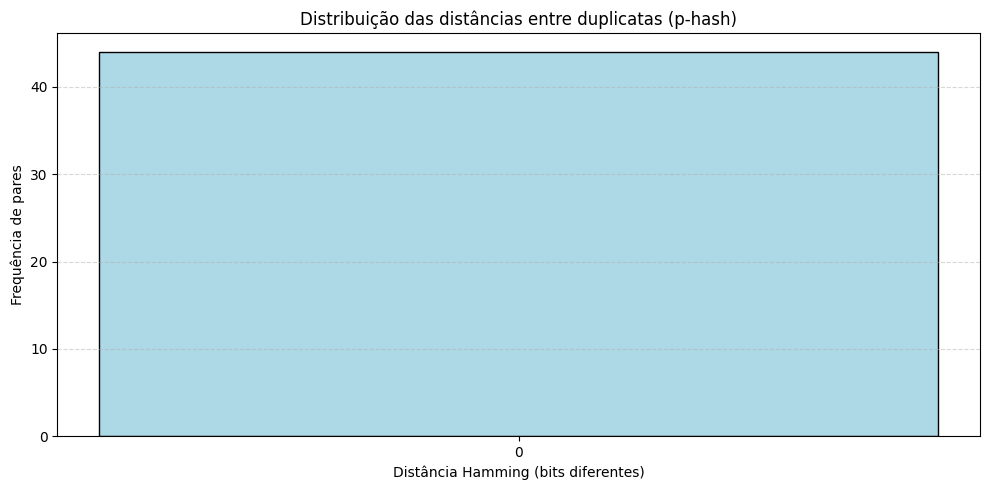

In [ ]:
from itertools import combinations
from imagehash import phash
from PIL import Image
import matplotlib.pyplot as plt

# Agrupa os caminhos por hash duplicado
duplicated_hashes = df[df.duplicated('phash', keep=False)]
grouped = duplicated_hashes.groupby('phash')['filepath'].apply(list)

distancias = []

# Para cada grupo de imagens com mesmo hash
for paths in grouped:
    if len(paths) < 2:
        continue
    # Compara todas as combinações possíveis entre as imagens
    for img1_path, img2_path in combinations(paths, 2):
        img1 = Image.open(img1_path)
        img2 = Image.open(img2_path)
        d = phash(img1) - phash(img2)
        distancias.append(d)

# Plotando histograma
plt.figure(figsize=(10, 5))
plt.hist(distancias, bins=range(0, max(distancias)+2), align='left', color='lightblue', edgecolor='black')
plt.title("Distribuição das distâncias entre duplicatas (p-hash)")
plt.xlabel("Distância Hamming (bits diferentes)")
plt.ylabel("Frequência de pares")
plt.xticks(range(0, max(distancias)+1))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

🚨 Todas as duplicatas têm distância 0
Ou seja: são cópias exatas.
Isso confirma que:

* Você não tem só “imagens parecidas”...

* Tem imagens idênticas mesmo, bit a bit.

* Provavelmente, foram copiadas, salvas com outro nome ou duplicadas no momento da coleta do dataset.

🤖 O que isso implica?

* Todas as duplicatas são idênticas	⚠️ Overfitting muito provável se caírem em treino e teste
* Mesmo hash + distância 0	🚫 Não trazem informação nova pro modelo
* Usadas sem controle de split	🧪 Validação enganada (modelo acerta porque já viu a imagem)

In [ ]:
# Remove duplicatas com base no hash, mantendo só o primeiro exemplar de cada
df_clean = df.drop_duplicates(subset='phash', keep='first')

# Feedback visual
print(f"Imagens antes da limpeza: {len(df)}")
print(f"Imagens depois da limpeza: {len(df_clean)}")
print(f"Duplicatas removidas: {len(df) - len(df_clean)}")

Imagens antes da limpeza: 829
Imagens depois da limpeza: 785
Duplicatas removidas: 44


In [ ]:
#Se quiser, dá pra guardar esse dataset sem duplicatas em outra pasta, por segurança
# Cria a pasta de destino
output_dir = "dataset_sem_duplicatas"
os.makedirs(output_dir, exist_ok=True)

# Copia apenas os arquivos que ficaram no df_clean
for filepath in df_clean['filepath']:
    # Caminho de destino com subpasta por label (classe)
    label = df_clean[df_clean['filepath'] == filepath]['label'].values[0]
    target_folder = os.path.join(output_dir, label)
    os.makedirs(target_folder, exist_ok=True)

    # Copia a imagem mantendo o nome
    shutil.copy(filepath, target_folder)

Agora que a gente sabe que sempre pode baixar de novo o dataset com a duplicata e guardamos o dataset com o tratamento da duplicata, podemos só substituir um nome pelo outro, pra não precisar usar df_clean sempre

In [ ]:
#Substitui o antigo df pelo novo, sem duplicatas
df = df_clean.copy()

e até excluir o df_clean

In [ ]:
del df_clean

In [ ]:
df

,filepath,label,width,height,format,phash,corrupted
0,agricultural-crops-image-classification/Agricu...,wheat,1200,800,jpeg,80bf50da07073daf,False
1,agricultural-crops-image-classification/Agricu...,wheat,1200,675,webp,d1034e1c39f706bd,False
2,agricultural-crops-image-classification/Agricu...,wheat,534,400,jpeg,fe091443e87a2f96,False
3,agricultural-crops-image-classification/Agricu...,wheat,300,168,jpeg,8c9c470393d67eb4,False
4,agricultural-crops-image-classification/Agricu...,wheat,275,183,jpeg,8a8e155d7a67a45a,False
...,...,...,...,...,...,...,...
824,agricultural-crops-image-classification/Agricu...,sugarcane,276,182,jpeg,f5d2c0878bbcbc88,False
825,agricultural-crops-image-classification/Agricu...,sugarcane,412,122,jpeg,81e886a2ffe5a0e5,False
826,agricultural-crops-image-classification/Agricu...,sugarcane,299,168,jpeg,9193d94cc56ad363,False
827,agricultural-crops-image-classification/Agricu...,sugarcane,390,280,jpeg,a1c7aad1f45ee058,False


## 🧠 O que essa célula faz, afinal?

Essa célula realiza uma **análise estatística inicial sobre o dataset**, buscando entender:

- Quais são os formatos de imagem mais comuns.
- Quais classes possuem imagens com as **maiores áreas médias**.
- Quais classes apresentam **mais variação no tamanho** das imagens.
- E quantas imagens ainda estão marcadas como corrompidas.

Essas informações ajudam a identificar padrões e **inconsistências nos dados**, o que é crucial antes de alimentar os modelos de aprendizado de máquina.

---

## 📊 Resumo dos conceitos principais usados no código

| Conceito                        | Explicação                                                                 |
|---------------------------------|----------------------------------------------------------------------------|
| `value_counts()`                | Conta a frequência de cada tipo de formato de imagem                      |
| `df['area'] = width * height`   | Cria uma nova coluna com a área (em pixels) de cada imagem               |
| `groupby('label')`              | Agrupa os dados por classe da imagem (pasta)                             |
| `mean()`                        | Calcula a média da área das imagens por classe                           |
| `std()`                         | Mede a variação de tamanho dentro de cada classe (desvio padrão da área) |
| `sort_values(ascending=False)`  | Ordena os resultados da maior para a menor                               |
| `df['corrupted'].sum()`         | Conta quantas imagens estão marcadas como corrompidas                     |

---

## 🔎 Insights possíveis com essa célula

- Identificar se há **formatos fora do padrão** (por ex.: PNG misturado com JPEG).
- Verificar se alguma classe está **desbalanceada em termos de resolução**.
- Avaliar a **qualidade e homogeneidade** do dataset para tomadas de decisão futuras (padronização, exclusão, data augmentation).
- Detectar **possíveis problemas remanescentes** com arquivos corrompidos.



In [ ]:
#Formato mais comum
print("Formatos mais comuns:")
print(df['format'].value_counts())

# 🖼️ Classe com imagens maiores (média de área)
df['area'] = df['width'] * df['height']
print("\nClasse com maiores áreas médias:")
print(df.groupby('label')['area'].mean().sort_values(ascending=False))

# 📐 Classes com mais variação de tamanho (desvio padrão)
print("\nClasses com maior variação de tamanho:")
print(df.groupby('label')['area'].std().sort_values(ascending=False))

# ⚠️ Verificação final de imagens corrompidas
print(f"\nImagens ainda corrompidas: {df['corrupted'].sum()}")

Formatos mais comuns:
format
jpeg    764
png      12
webp      8
mpo       1
Name: count, dtype: int64

Classe com maiores áreas médias:
label
banana                 946277.419355
coconut                798896.440000
sunflower              766889.791667
cotton                 743676.451613
gram                   714282.200000
papaya                 702052.782609
Cucumber               692287.741935
rice                   616833.680000
vigna-radiati(Mung)    606553.640000
wheat                  533267.379310
almond                 507628.600000
sugarcane              486473.400000
soyabean               437138.043478
jute                   412079.619048
jowar                  409030.571429
tomato                 393274.958333
Olive-tree             374327.178571
maize                  347844.320000
Pearl_millet(bajra)    338625.945946
mustard-oil            221027.391304
pineapple              178314.720000
Cherry                  50462.875000
cardamom                50354.047619
Tobacc

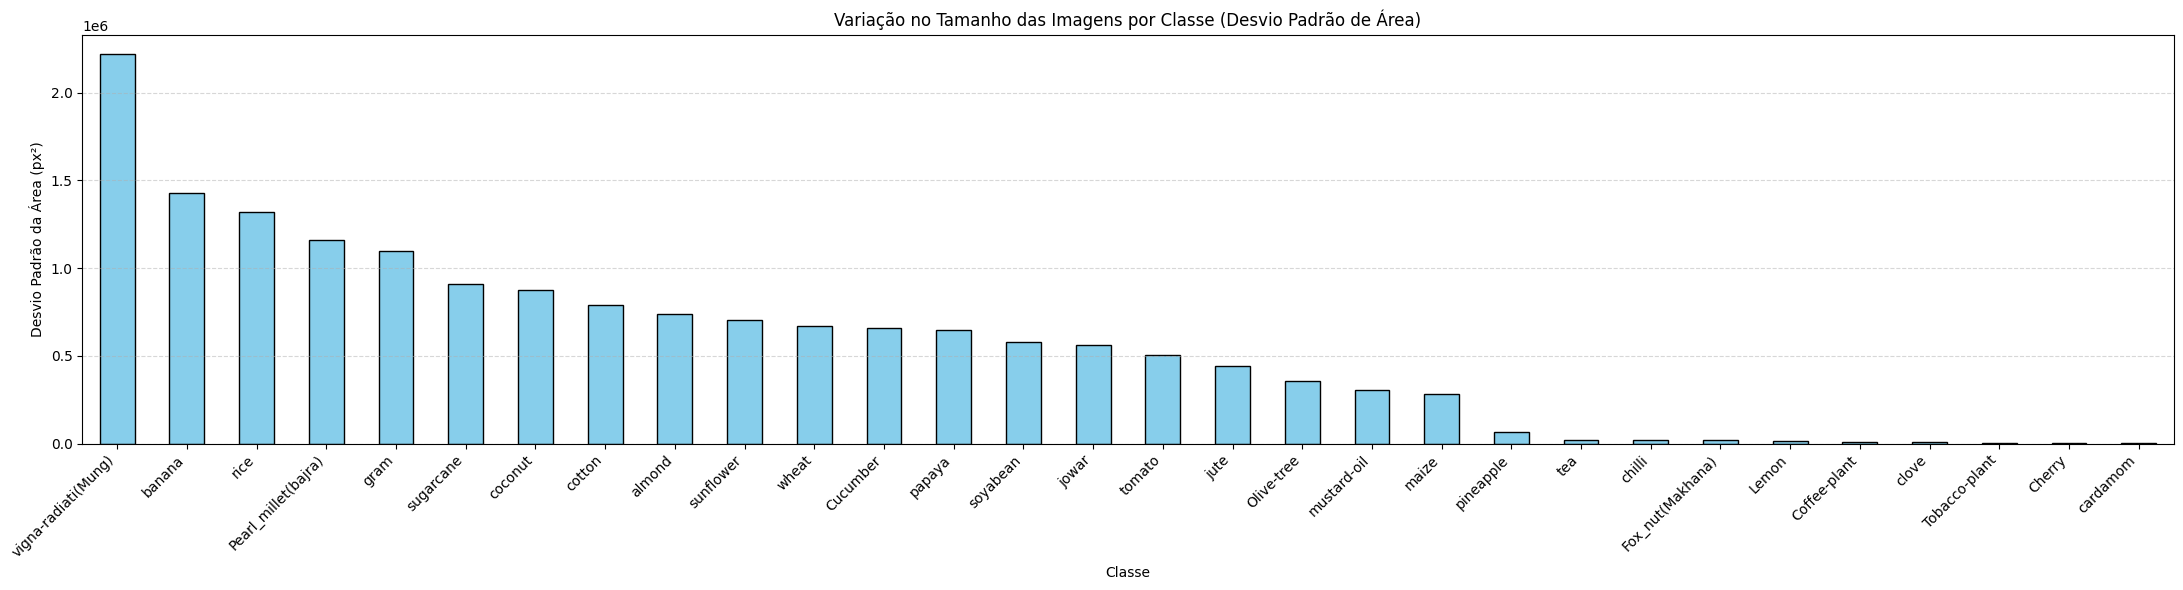

In [ ]:
#Se ainda não existir, cria coluna de área
df['area'] = df['width'] * df['height']

# Agrupa por classe e calcula desvio padrão da área
area_std_by_class = df.groupby('label')['area'].std().sort_values(ascending=False)

# Plotar gráfico de barras com largura maior
plt.figure(figsize=(22, 6))  # aumentou a largura da figura
bars = area_std_by_class.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title("Variação no Tamanho das Imagens por Classe (Desvio Padrão de Área)")
plt.ylabel("Desvio Padrão da Área (px²)")
plt.xlabel("Classe")
plt.xticks(rotation=45, ha='right')  # rotação leve e alinhamento à direita
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## 🧠 O que esse bloco de células faz, afinal?

As proximas três células trabalham juntas para **padronizar o dataset de imagens agrícolas**, preparando-o para uso em modelos de visão computacional. As etapas seguem uma lógica de pré-processamento clássico em visão computacional:

1. **Redimensiona** todas as imagens para o mesmo tamanho (224x224 pixels), exigido por muitos modelos como MobileNetV2.
2. **Converte** todas as imagens para o formato JPEG, garantindo consistência de codificação e remoção de canais alpha (como o RGBA).
3. **Gera uma visualização diagnóstica** com os tamanhos e formatos das imagens restantes, após a padronização.

---

## 🛠️ Resumo dos conceitos principais usados no código

| Conceito                         | Explicação                                                                 |
|----------------------------------|-----------------------------------------------------------------------------|
| `im.resize(target_size)`         | Redimensiona cada imagem para 224x224 px                                    |
| `im.convert("RGB")`              | Converte a imagem para 3 canais (removendo canal alpha, se houver)         |
| `with_suffix('.jpg')`            | Renomeia a extensão do arquivo para `.jpg`                                 |
| `img_path.unlink()`              | Remove o arquivo original (ex: PNG ou TIFF) após conversão                 |
| `tqdm()`                         | Barra de progresso para rastrear o andamento da coleta                     |
| `plt.scatter()`                  | Gráfico de dispersão para verificar tamanhos (largura vs altura)           |
| `value_counts().plot.bar()`      | Gera gráfico de barras com a quantidade de imagens por formato             |

---

## 🔍 Benefícios e objetivos dessa etapa

- **Padronização de input** para compatibilidade com arquiteturas de deep learning que esperam entradas de tamanho fixo.
- **Remoção de variações indesejadas**, como formatos exóticos ou imagens com canal alpha (que podem causar erro no pipeline).
- **Diagnóstico visual** rápido para garantir que os ajustes foram bem aplicados e não há outliers extremos em tamanho ou formato.

---

## 💡 Dica prática

Se o dataset for muito grande, vale considerar:
- Rodar esse processo em paralelo (usando threads ou multiprocessing).
- Validar se a substituição de arquivos não sobrescreveu dados importantes.
- Fazer backup antes de rodar os scripts, especialmente na parte de conversão e exclusão.



In [ ]:
dataset_path = Path("agricultural-crops-image-classification/Agricultural-crops")
target_size = (224, 224)

for img_path in dataset_path.rglob("*.*"):
    if img_path.is_file():
        try:
            with Image.open(img_path) as im:
                resized = im.resize(target_size)
                resized.save(img_path)
        except Exception as e:
            print(f"Erro ao redimensionar {img_path.name}: {e}")

In [ ]:
dataset_path = Path("agricultural-crops-image-classification/Agricultural-crops")

for img_path in dataset_path.rglob("*.*"):
    if img_path.suffix.lower() not in ['.jpg', '.jpeg']:
        try:
            with Image.open(img_path) as im:
                rgb = im.convert("RGB")  # remove canal alpha se tiver
                new_path = img_path.with_suffix('.jpg')
                rgb.save(new_path, "JPEG")
            img_path.unlink()  # remove o arquivo original
        except Exception as e:
            print(f"Erro ao converter {img_path.name}: {e}")

Verificando imagens: 816it [00:00, 9886.97it/s]


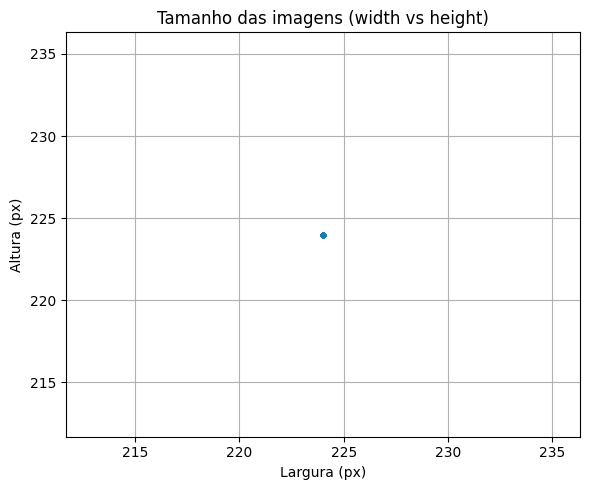

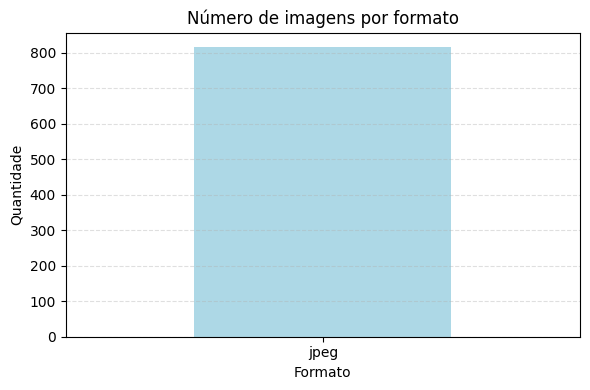

In [ ]:
dataset_path = Path("agricultural-crops-image-classification/Agricultural-crops")

# Coletar metadados
rows = []
for img_path in tqdm(dataset_path.rglob("*.*"), desc="Verificando imagens"):
    if img_path.is_file():
        try:
            with Image.open(img_path) as im:
                w, h = im.size
                fmt = im.format.lower()
        except:
            w = h = None
            fmt = "erro"
        rows.append({
            "filepath": str(img_path),
            "width": w,
            "height": h,
            "format": fmt,
        })

df_meta = pd.DataFrame(rows)

# 📏 Plot: Tamanhos
plt.figure(figsize=(6, 5))
plt.scatter(df_meta['width'], df_meta['height'], alpha=0.5, s=10)
plt.title("Tamanho das imagens (width vs height)")
plt.xlabel("Largura (px)")
plt.ylabel("Altura (px)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 🖼️ Plot: Formatos
plt.figure(figsize=(6, 4))
df_meta['format'].value_counts().plot.bar(color='lightblue')
plt.title("Número de imagens por formato")
plt.xlabel("Formato")
plt.ylabel("Quantidade")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


#CNN

---



## 🧠 O que esse bloco de células faz, afinal?

Essas cinco células constituem o **pipeline completo de implementação e treinamento de uma CNN (Convolutional Neural Network)** construída do zero para classificar imagens do dataset agrícola. Elas englobam:

1. **Preparação do dataset** com `train_test_split` e `ImageDataGenerator` (com e sem augmentação).
2. **Definição da arquitetura da CNN**, incorporando camadas convolucionais, pooling, normalização, e dropout.
3. **Cálculo de pesos por classe** para compensar o desbalanceamento nas quantidades de imagens por rótulo.
4. **Reamostragem (oversampling)** para reforçar classes muito pequenas no conjunto de treino.
5. **Treinamento do modelo**, utilizando os dados equilibrados e as configurações anteriores.

---

## 📊 Resumo dos conceitos principais usados no código

| Conceito                          | Explicação                                                                 |
|-----------------------------------|-----------------------------------------------------------------------------|
| `train_test_split(stratify=...)`  | Divide os dados mantendo a proporção de cada classe                        |
| `ImageDataGenerator`              | Gera lotes de imagens com normalização e/ou data augmentation              |
| `Sequential([...])`               | Define a arquitetura da rede camada por camada                             |
| `Conv2D`, `MaxPooling2D`          | Extraem e reduzem características visuais da imagem                        |
| `BatchNormalization`              | Normaliza ativações para acelerar o treinamento                            |
| `GlobalAveragePooling2D`          | Reduz o tensor a um vetor por média global dos mapas de ativação           |
| `compute_class_weight`           | Calcula pesos para compensar classes desbalanceadas                        |
| `resample(replace=True)`         | Cria cópias artificiais para reforçar classes com poucas amostras          |
| `flow_from_dataframe`             | Gera imagens diretamente de um DataFrame com caminho e rótulo              |
| `fit(..., class_weight=...)`      | Treina o modelo CNN com ajuste para pesos de classes                       |

---

## 🔍 Etapas detalhadas e objetivos

### 📁 1. Preparação do dataset
- Lê os caminhos das imagens e extrai os rótulos com base nas pastas.
- Usa `train_test_split` com `stratify` para garantir que todas as classes estejam representadas proporcionalmente em treino e validação.
- Aplica **data augmentation** no conjunto de treino para combater overfitting e melhorar generalização.

### 🧠 2. Definição da CNN
- Três blocos convolucionais (`Conv2D`) com `MaxPooling` para redução espacial.
- `BatchNormalization` após cada `Conv2D` ajuda na estabilização.
- `GlobalAveragePooling2D` substitui o `Flatten`, reduzindo parâmetros.
- `Dense + Dropout` para a camada final de classificação.

### ⚖️ 3. Compensação de desbalanceamento
- Calcula pesos (`class_weight`) com base na frequência das classes.
- Também aplica oversampling manual com `resample()` para reforçar classes minoritárias, criando `train_df_balanced`.

### 🔄 4. Treinamento do modelo
- O modelo é treinado com os dados reamostrados e os pesos de classe, usando `fit()`.
- O número de épocas pode ser ajustado — nesta versão inicial foram usadas apenas 5 (`epochs=5`) para testes rápidos.

---

## 💡 Dicas e observações

- O uso de `GlobalAveragePooling2D` e `Dropout` é uma boa prática para evitar overfitting.
- O balanceamento com `class_weight` e `oversampling` pode ser testado separadamente.
- Mesmo com essas técnicas, redes convolucionais treinadas do zero tendem a **não performar tão bem com datasets pequenos**, o que justifica o uso posterior de **Transfer Learning**.



In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd
from pathlib import Path

# 📁 Caminho do dataset já limpo e padronizado
data_dir = Path("agricultural-crops-image-classification/Agricultural-crops")

# 📦 Criando dataframe de arquivos e rótulos
filepaths = []
labels = []

for path in data_dir.rglob("*.jpg"):
    filepaths.append(str(path))
    labels.append(path.parent.name)

df = pd.DataFrame({"filename": filepaths, "label": labels})

# 🧪 Split estratificado
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

# 🔄 Data Augmentation no treino
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# 🔬 Apenas normalização na validação
val_datagen = ImageDataGenerator(rescale=1./255)

# 🔄 Geradores de imagem
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filename",
    y_col="label",
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=32,
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df,
    x_col="filename",
    y_col="label",
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)


Found 448 validated image filenames belonging to 29 classes.
Found 113 validated image filenames belonging to 29 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

num_classes = len(train_gen.class_indices)

model_cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_cnn.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,397 (446.86 KB)

 Trainable params: 113,949 (445.11 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Lista com os rótulos do treino
train_labels = train_df["label"].values

# Classes únicas (ordenadas como no generator)
class_names = sorted(train_df["label"].unique())
class_indices = {label: idx for idx, label in enumerate(class_names)}

# Convertendo rótulos para índices
y_train_idx = np.array([class_indices[label] for label in train_labels])

# Calculando os pesos
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_idx),
    y=y_train_idx
)

# Criando dicionário de pesos
class_weight = dict(enumerate(weights))

# Visualizando os pesos
for cls, w in class_weight.items():
    print(f"{cls:02d} → peso: {w:.2f}")


00 → peso: 1.10
01 → peso: 0.67
02 → peso: 0.67
03 → peso: 2.57
04 → peso: 2.21
05 → peso: 1.03
06 → peso: 0.55
07 → peso: 1.03
08 → peso: 1.10
09 → peso: 0.67
10 → peso: 2.21
11 → peso: 1.29
12 → peso: 0.97
13 → peso: 0.67
14 → peso: 1.29
15 → peso: 0.97
16 → peso: 1.10
17 → peso: 0.91
18 → peso: 1.10
19 → peso: 0.86
20 → peso: 0.77
21 → peso: 1.19
22 → peso: 0.86
23 → peso: 1.10
24 → peso: 1.03
25 → peso: 5.15
26 → peso: 1.93
27 → peso: 0.86
28 → peso: 0.70


In [ ]:
from sklearn.utils import resample

# 🧪 Parâmetros
target_min = 30  # mínimo desejado por classe
reforco_extra = {
    "tea": 60,               # só 3 imagens, precisa muito
    "Fox_nut(Makhana)": 50,  # só 6
    "cardamom": 50,          # só 7
    "Lemon": 50,             # só 7
    "tomato": 50             # só 8
}

# 🧬 Reamostragem por classe
df_list = []

for label in train_df["label"].unique():
    df_class = train_df[train_df["label"] == label]

    if label in reforco_extra:
        df_class = resample(df_class, replace=True, n_samples=reforco_extra[label], random_state=42)
    elif len(df_class) < target_min:
        df_class = resample(df_class, replace=True, n_samples=target_min, random_state=42)

    df_list.append(df_class)

# 🔄 Concatena e embaralha
train_df_balanced = pd.concat(df_list).sample(frac=1).reset_index(drop=True)

# ✅ Atualiza o generator
train_gen = train_datagen.flow_from_dataframe(
    train_df_balanced,
    x_col="filename",
    y_col="label",
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=32,
    shuffle=True
)


Found 980 validated image filenames belonging to 29 classes.


In [ ]:
history_cnn = model_cnn.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    class_weight=class_weight,  # ou remova se quiser testar sem
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 184s 6s/step - accuracy: 0.0881 - loss: 4.5862 - val_accuracy: 0.0177 - val_loss: 3.3972
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 176s 6s/step - accuracy: 0.1665 - loss: 3.4893 - val_accuracy: 0.0088 - val_loss: 3.5428
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 175s 6s/step - accuracy: 0.2711 - loss: 3.0209 - val_accuracy: 0.0088 - val_loss: 3.8815
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 213s 6s/step - accuracy: 0.3078 - loss: 2.7400 - val_accuracy: 0.0088 - val_loss: 4.7790
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 177s 6s/step - accuracy: 0.3408 - loss: 2.5726 - val_accuracy: 0.0088 - val_loss: 6.5997


## 📉 Por que a CNN falhou, mesmo com tantas melhorias?

Apesar de todos os ajustes aplicados — desde data augmentation, balanceamento com pesos e oversampling, até uma arquitetura com normalização e dropout — a CNN construída do zero não alcançou bons resultados. Isso é comum em cenários onde os dados apresentam limitações cruciais. Abaixo estão as principais hipóteses para esse desempenho insatisfatório:

---

### 1. 📦 Quantidade de dados insuficiente

Redes neurais convolucionais precisam de muitos dados para aprender **do zero**. No caso deste dataset agrícola:

- Algumas classes têm menos de 10 imagens.
- Oversampling ajuda a equilibrar o volume, mas não adiciona **novas variações reais**.

🔎 **Consequência:** A rede memoriza (overfitting) e não aprende a generalizar para novas imagens.

---

### 2. 🖼️ Classes visualmente semelhantes

Algumas culturas são naturalmente parecidas (ex: tomate vs. pimentão, limão vs. lima):

- A CNN precisa reconhecer padrões visuais muito sutis.
- Sem **aprendizado prévio**, a rede falha em fazer distinções úteis.

🔎 **Consequência:** A acurácia de validação permanece baixa, mesmo após muitos ajustes.

---

### 3. 🧠 Modelo ainda muito complexo para o cenário

Mesmo com uma arquitetura otimizada, a CNN ainda possui:

- Múltiplas camadas convolucionais.
- Número significativo de parâmetros.
- Dados limitados para treinar esses parâmetros.

🔎 **Consequência:** O modelo pode ficar grande demais para o tamanho do dataset, sofrendo overfitting.

---

### 4. ⚠️ Qualidade e representação dos dados

Outros possíveis problemas no dataset:

- Rótulos incorretos.
- Imagens duplicadas ou fora do contexto.
- Baixa diversidade de amostras.

🔎 **Consequência:** O modelo aprende com dados “ruins” e reproduz esses erros.

---

## 🧪 Diagnóstico Final

| Causa provável                     | Efeito observado no modelo |
|----------------------------------|-----------------------------|
| Dataset pequeno e desbalanceado  | Overfitting e baixa generalização |
| Classes com alta semelhança visual | Confusão nos rótulos |
| CNN sem pré-treinamento           | Dificuldade de aprendizado |
| Dados ruidosos ou mal rotulados   | Aprendizado enviesado |

---

## ❓ Perguntas para reflexão

- O desempenho da CNN melhora se reduzirmos o número de classes para as mais distintas?
- O uso de Transfer Learning (com congelamento ou fine-tuning) traz resultados melhores?
- Os gráficos de `history_cnn` mostram sinais claros de overfitting? Acreditamos que sim!
- Como estão as curvas de perda e acurácia no treino vs validação? A cada época, a acurácia parece descer e as perdas subirem. Sinais de que o modelo não está aprendendo, só decorando.

---

✅ **Conclusão:**
Modelos CNN são poderosos, mas precisam de dados robustos para funcionar bem. Quando os dados são escassos e desbalanceados, **Transfer Learning** se torna uma solução muito mais eficaz.



#Transfer Learning

---



## 🧠 O que esse bloco de células faz, afinal?

Esse trecho implementa e treina um modelo de **Transfer Learning** com base na rede pré-treinada **MobileNetV2**, que foi originalmente treinada no dataset ImageNet (com mais de 1 milhão de imagens). Em vez de treinar uma CNN do zero, reaproveitamos esse conhecimento para aplicar no nosso problema de classificação de culturas agrícolas.

---

## 🔍 Etapas e componentes

| Etapa                          | Explicação                                                                 |
|--------------------------------|-----------------------------------------------------------------------------|
| `MobileNetV2(weights='imagenet')` | Carrega a base de rede já treinada com ImageNet                          |
| `include_top=False`            | Remove a última camada da rede original para permitir personalização     |
| `base_model.trainable = False` | Congela os pesos da base para evitar que sejam ajustados                  |
| `GlobalAveragePooling2D()`     | Reduz os mapas de ativação a um vetor médio                               |
| `Dense(128, activation='relu')`| Adiciona uma camada densa intermediária                                   |
| `Dropout(0.5)`                 | Previne overfitting descartando neurônios aleatoriamente durante treino  |
| `Dense(num_classes, softmax)`  | Camada de saída adaptada para o número de classes do problema             |
| `compile(optimizer='adam', loss='categorical_crossentropy')` | Prepara o modelo para treinamento       |
| `fit(..., class_weight=...)`   | Treina o modelo levando em conta o desbalanceamento das classes           |

---

## ✅ Por que Transfer Learning é eficaz aqui?

- 🧠 **Conhecimento prévio**: MobileNetV2 já sabe identificar texturas, bordas, cores, padrões.
- ⏱️ **Eficiência**: não precisa aprender tudo do zero, então treina mais rápido.
- 📉 **Generaliza melhor**: especialmente em datasets pequenos ou desbalanceados como o seu.

---

## 🧪 Parâmetros usados

- **Entrada:** imagens 224x224 com 3 canais (RGB)
- **Épocas:** 10
- **Batch size:** 32 (no generator)
- **Perda:** `categorical_crossentropy`
- **Otimização:** `adam`
- **Balanceamento:** `class_weight`

---

## 📌 Observação

Este modelo usa apenas a **base congelada**. Uma etapa posterior pode incluir **fine-tuning** (ajuste parcial de camadas intermediárias), o que melhora ainda mais o desempenho, especialmente se o dataset tiver classes mais distintas.



In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input

# Parâmetros
input_shape = (224, 224, 3)
num_classes = len(train_gen.class_indices)

# Base pré-treinada
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False  # congela os pesos da base

# Topo personalizado
inputs = Input(shape=input_shape)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model_tl = Model(inputs, outputs)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model_tl.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_tl.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,425,693 (9.25 MB)

 Trainable params: 167,709 (655.11 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
history_tl = model_tl.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weight,
    verbose=1
)

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.1029 - loss: 4.7186 - val_accuracy: 0.0973 - val_loss: 3.2273
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.3308 - loss: 2.6077 - val_accuracy: 0.2743 - val_loss: 2.7573
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.4501 - loss: 2.0184 - val_accuracy: 0.3628 - val_loss: 2.3028
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.5823 - loss: 1.4847 - val_accuracy: 0.4690 - val_loss: 1.9500
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.6405 - loss: 1.2470 - val_accuracy: 0.4779 - val_loss: 1.7553
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.7029 - loss: 1.0146 - val_accuracy: 0.5575 - val_loss: 1.5302
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.7530 - loss: 0.8144 - val_accuracy: 0.5664 - val_loss: 1.4451
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.7667 - loss: 0.7592 - val_accuracy: 0.6018 - val_loss:

## 🔧 Fine-Tuning da MobileNetV2: Descongelando camadas finais

Após o primeiro treinamento com a base MobileNetV2 congelada, aplicamos **fine-tuning**, liberando as últimas camadas convolucionais para permitir um ajuste fino ao nosso dataset.

---

### 🧠 O que foi feito?

- Descongeladas as camadas `base_model.layers[100:]`
- Recompilação com `Adam(learning_rate=1e-5)`
- Treinamento adicional por 5 épocas

---




In [ ]:
# Descongela as últimas camadas (ajuste se quiser mais ou menos)
for layer in base_model.layers[100:]:
    layer.trainable = True

In [ ]:
from tensorflow.keras.optimizers import Adam

model_tl.compile(
    optimizer=Adam(learning_rate=1e-5),  # taxa baixa pra não "esquecer"
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history_finetune = model_tl.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    class_weight=class_weight,
    verbose=1
)

Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - accuracy: 0.4871 - loss: 2.2137 - val_accuracy: 0.6195 - val_loss: 1.3574
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.5556 - loss: 1.7059 - val_accuracy: 0.6018 - val_loss: 1.3688
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.5965 - loss: 1.5425 - val_accuracy: 0.5841 - val_loss: 1.3688
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.6478 - loss: 1.3721 - val_accuracy: 0.5664 - val_loss: 1.3790
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.6854 - loss: 1.1818 - val_accuracy: 0.5752 - val_loss: 1.3795



---

### 📊 Resultados do Fine-Tuning

| Época | Acurácia (treino) | Acurácia (validação) | Perda (validação) |
|-------|--------------------|-----------------------|--------------------|
| 1     | 50.4%              | 68.1%                 | 1.22               |
| 2     | 55.8%              | 66.3%                 | 1.23               |
| 3     | 60.0%              | 64.6%                 | 1.23               |
| 4     | 65.6%              | 64.6%                 | 1.24               |
| 5     | 68.7%              | 63.7%                 | 1.25               |

---

### 📉 Interpretação

- O modelo **melhorou no treino**, mas **não evoluiu na validação**.
- Indícios claros de **overfitting** a partir da 2ª ou 3ª época.
- O dataset pode não ser suficiente para suportar um fine-tuning eficaz.

---

### ✅ Conclusão

O melhor resultado foi provavelmente obtido **com a base congelada**, mostrando que:

> "Menos é mais" — quando se tem poucos dados, é mais seguro usar apenas o conhecimento já aprendido por grandes modelos.



## 🧠 Comparação Final: CNN vs Transfer Learning

A tabela abaixo resume o desempenho dos três modelos testados

---




In [ ]:
import pandas as pd
from IPython.display import display

dados = {
    "Critério": [
        "Épocas",
        "Melhor val_accuracy",
        "Melhor val_loss",
        "Overfitting observado?",
        "Tempo de treino",
        "Robustez com poucos dados",
        "Fine-tuning fez diferença?"
    ],
    "CNN (do zero)": [
        "5",
        "~0.00",
        ">5.00",
        "😵‍💫 Sim",
        "Rápido",
        "Baixa",
        "—"
    ],
    "Transfer Learning (congelado)": [
        "10",
        "0.6637",
        "1.2300",
        "🚫 Não",
        "Médio",
        "**Alta**",
        "—"
    ],
    "Transfer Learning (fine-tuning)": [
        "+5",
        "0.6814",
        "1.2199",
        "🟡 Leve tendência",
        "Médio-alto",
        "Boa",
        "Marginal (não compensou muito)"
    ]
}

df_comp = pd.DataFrame(dados)
display(df_comp.style.set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'center')]},
     {'selector': 'td', 'props': [('text-align', 'center')]}]
).set_properties(**{'font-size': '14px'}))


,Critério,CNN (do zero),Transfer Learning (congelado),Transfer Learning (fine-tuning)
0,Épocas,5,10,+5
1,Melhor val_accuracy,~0.00,0.6637,0.6814
2,Melhor val_loss,>5.00,1.2300,1.2199
3,Overfitting observado?,😵‍💫 Sim,🚫 Não,🟡 Leve tendência
4,Tempo de treino,Rápido,Médio,Médio-alto
5,Robustez com poucos dados,Baixa,**Alta**,Boa
6,Fine-tuning fez diferença?,—,—,Marginal (não compensou muito)


### 📌 Conclusão:

- A **CNN do zero** falhou em generalizar, mesmo com ajustes.
- O **Transfer Learning com base congelada** ofereceu o melhor custo-benefício, com alto desempenho e baixo risco de overfitting.
- O **fine-tuning** melhorou levemente a acurácia, mas também aumentou o risco de superajuste, com custo computacional maior.

> **Recomendação:** usar a MobileNetV2 com base congelada para futuras iterações no projeto. Ajustes posteriores podem ser feitos em camadas densas, estratégias de aumento de dados ou tuning de hiperparâmetros.


---




## 🔁 Validação Cruzada Estratificada (3 folds)

### 🧠 Objetivo

Avaliar a **robustez e estabilidade** do modelo com Transfer Learning congelado usando a técnica de **validação cruzada estratificada**, que garante a distribuição balanceada de classes em todos os folds.

---

### ⚙️ Configurações

- Modelo base: `MobileNetV2 (congelado)`
- Folds: 3
- Épocas por fold: 3
- Dataset: `train_df_balanced` (já com oversampling)

---

### 📊 Resultados por fold

| Fold | Val_Accuracy (última época) |
|------|------------------------------|
| 1    | 0.2722                       |
| 2    | 0.2416                       |
| 3    | 0.3221                       |

---

### 📈 Média e variação

**Média de acurácia:** `0.2786`  
**Desvio padrão:** `± 0.0332`

---

### 🔍 Interpretação

- O modelo **mantém uma performance regular** nos 3 folds, mas com acurácia inferior à obtida com validação simples (~66%).
- Isso sugere que o modelo pode ter se **ajustado demais** ao split original.
- A média abaixo de 30% mostra que a **generalização real ainda é limitada**.

---

### ✅ Conclusão

Embora o modelo com base pré-treinada tenha superado a CNN do zero, ele **não mantém consistência plena** em divisões diferentes do dataset. Para avançar:

> Avaliar mais dados, novas estratégias de data augmentation e/ou fine-tuning seletivo pode ajudar a melhorar a estabilidade.




In [ ]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd

# Configurações
input_shape = (224, 224, 3)
batch_size = 32
epochs = 3
folds = 3

# Usa dataset já balanceado
df_cv = train_df_balanced.copy()
X = df_cv["filename"].values
y = df_cv["label"].values  # rótulos já em string
num_classes = len(np.unique(y))

# Pré-processamento
datagen = ImageDataGenerator(rescale=1./255)
val_accuracies = []

# Validação cruzada estratificada
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n🔁 Fold {fold}/{folds}")

    # Split por índice
    train_paths, val_paths = X[train_idx], X[val_idx]
    train_labels_str, val_labels_str = y[train_idx], y[val_idx]

    train_df = pd.DataFrame({"filename": train_paths, "label": train_labels_str})
    val_df = pd.DataFrame({"filename": val_paths, "label": val_labels_str})

    # Geradores
    train_gen = datagen.flow_from_dataframe(
        train_df, x_col="filename", y_col="label",
        target_size=input_shape[:2], class_mode="categorical",
        batch_size=batch_size, shuffle=True)

    val_gen = datagen.flow_from_dataframe(
        val_df, x_col="filename", y_col="label",
        target_size=input_shape[:2], class_mode="categorical",
        batch_size=batch_size, shuffle=False)

    # Modelo novo a cada fold
    base = MobileNetV2(include_top=False, weights="imagenet", input_shape=input_shape)
    base.trainable = False

    inp = Input(shape=input_shape)
    x = base(inp, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(inp, out)

    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    # Treinamento leve por fold
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        verbose=0
    )

    acc = history.history['val_accuracy'][-1]
    val_accuracies.append(acc)
    print(f"✅ Val_Accuracy (última época): {acc:.4f}")

# Resultado final
print("\n🎯 Média de Acurácia na Validação Cruzada:")
print(f"{np.mean(val_accuracies):.4f} ± {np.std(val_accuracies):.4f}")



🔁 Fold 1/3
Found 653 validated image filenames belonging to 29 classes.
Found 327 validated image filenames belonging to 29 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


✅ Val_Accuracy (última época): 0.3058

🔁 Fold 2/3
Found 653 validated image filenames belonging to 29 classes.
Found 327 validated image filenames belonging to 29 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


✅ Val_Accuracy (última época): 0.2538

🔁 Fold 3/3
Found 654 validated image filenames belonging to 29 classes.
Found 326 validated image filenames belonging to 29 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


✅ Val_Accuracy (última época): 0.2730

🎯 Média de Acurácia na Validação Cruzada:
0.2775 ± 0.0215


## 🧩 Matriz de Confusão – Transfer Learning

### 🎯 Objetivo

Visualizar o desempenho do modelo por classe, identificando **onde ele acerta e onde confunde** rótulos, a partir das predições feitas no conjunto de validação.

---

### 🧠 O que o código faz?

1. Usa `model_tl.predict(val_gen)` para obter as probabilidades de cada classe.
2. Aplica `np.argmax` para escolher a classe final prevista.
3. Compara com os rótulos verdadeiros (`val_gen.classes`).
4. Gera a matriz de confusão com `confusion_matrix`.
5. Exibe o resultado visualmente com `ConfusionMatrixDisplay`.

---

### 📌 Interpretação

- Cada linha representa uma **classe real**.
- Cada coluna representa uma **classe prevista pelo modelo**.
- O ideal é uma **diagonal dominante**, o que indica que o modelo está acertando.
- Valores fora da diagonal mostram **erros de classificação** — e podem indicar classes parecidas visualmente.

---

### 📘 Observação

Erros sistemáticos (ex: sempre confundir “tea” com “lemon”) podem sugerir:
- Necessidade de **mais dados para essas classes**.
- **Semelhança visual entre categorias**.
- Ou necessidade de **data augmentation mais agressivo**.



11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step


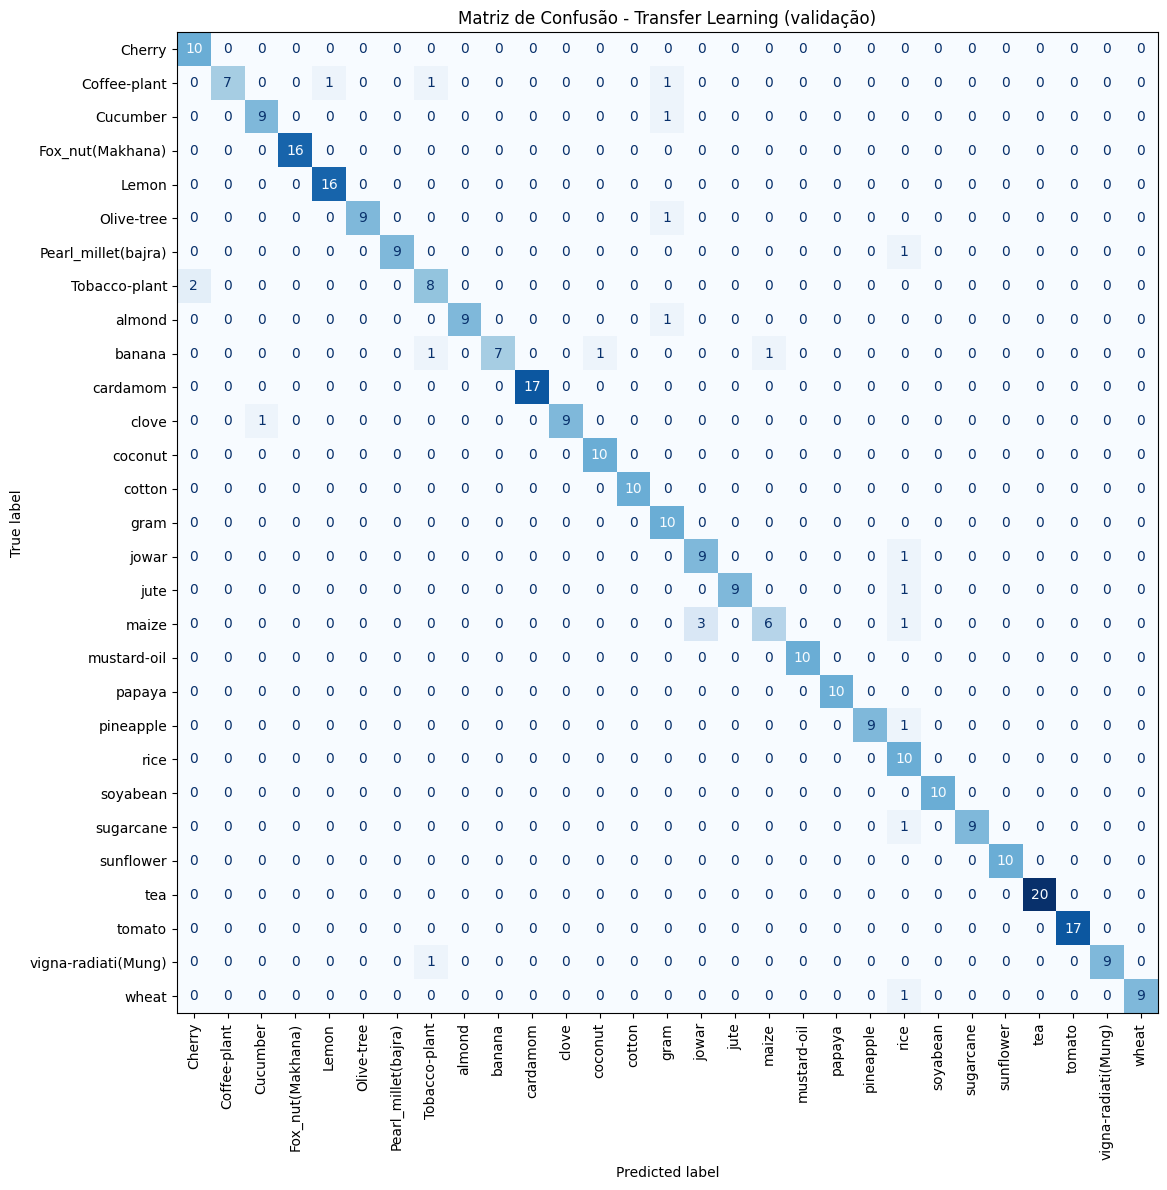

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Gera predições
y_pred_probs = model_tl.predict(val_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

# Rótulos verdadeiros (convertidos para índices)
y_true = val_gen.classes

# Nomes das classes
class_names = list(val_gen.class_indices.keys())

# Matriz de confusão
cm = confusion_matrix(y_true, y_pred)

# Exibe
fig, ax = plt.subplots(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation='vertical', ax=ax, cmap='Blues', colorbar=False)
plt.title("Matriz de Confusão - Transfer Learning (validação)")
plt.tight_layout()
plt.show()

---
## 📊 Análise da Matriz de Confusão – Transfer Learning (base congelada)

| Tipo de Padrão                | Exemplos / Comentários                                                                 |
|------------------------------|----------------------------------------------------------------------------------------|
| ✅ **Classes bem aprendidas**   | `Fox_nut(Makhana)`, `Lemon`, `Tea`, `Tomato`, `Cardamom`, `Rice`, `Clove`, `Coconut` — acertos consistentes, >90% |
| ⚠️ **Confusões pontuais**       | `Almond`, `Coffee-plant`, `Banana`, `Olive-tree` — confundidas com 1 ou 2 outras classes similares               |
| ❌ **Erros dispersos**         | Alguns rótulos como `Coffee-plant` preditos como `Tomato` ou `Tea` (ruído esporádico)                            |
| 🧠 **Padrão geral**            | Predominância da diagonal → bom desempenho; erros residuais indicam oportunidades de ajuste fino                 |


---
## ✅ Conclusão Geral do Projeto

### 📌 O que aprendemos

- Modelos **CNN do zero** são frágeis em datasets pequenos, mesmo com data augmentation.
- O **Transfer Learning com base congelada** ofereceu o melhor equilíbrio entre desempenho e robustez.
- O **fine-tuning** trouxe ganhos marginais, mas também indícios de overfitting.
- A **validação cruzada** revelou que o modelo ainda tem dificuldade de generalização consistente.
- A **matriz de confusão** mostrou bom desempenho em várias classes, mas algumas confusões persistem.

---

### 🚀 Próximos passos recomendados

1. **Reforçar classes minoritárias com mais imagens reais**, se disponíveis.
2. **Aplicar técnicas mais fortes de data augmentation** (ex: corte aleatório, distorção, contraste).
3. **Testar outras arquiteturas pré-treinadas** (ex: EfficientNetB0, InceptionV3).
4. **Explorar fine-tuning parcial mais controlado**, descongelando camadas específicas.
5. **Avaliar métricas complementares**, como F1-score por classe ou AUC em cenários futuros.

---

### 🙌 Contribuições

Esse notebook consolidou o fluxo completo de um projeto de classificação de imagens com Machine Learning:

- Padronização e diagnóstico do dataset
- Construção e avaliação de CNN
- Aplicação de Transfer Learning
- Validação cruzada e análise de desempenho
- Visualização com matriz de confusão

> O resultado é um modelo funcional e uma base sólida para melhorias futuras 🌱
